# An implementation of GPT2 in tinygrad

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": True
}

### Encoding

In [2]:
import pathlib
import textwrap
import tiktoken

from tinygrad import Tensor, nn


class TinyEncoder:

    def __init__(self):
        self.tokenizer = tiktoken.get_encoding("gpt2")

    def __call__(self, text:str) -> Tensor:
        token_ids = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        token_ids = Tensor(token_ids)
        return token_ids

    def decode(self, idx: Tensor) -> str:
        return self.tokenizer.decode()
        

In [3]:
import requests as r


response = r.get("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt")
response.raise_for_status()
content = response.text
text = content
pathlib.Path('the-verdict.txt').write_text(content)

20479

In [4]:
Tensor.manual_seed(42)
encoder = TinyEncoder()
embedding = encoder(text)
print(embedding.numpy(), embedding.shape)


[  40  367 2885 ...  286 1242  526] (5145,)


### Multi-head Attention

In [5]:
import math
from tinygrad import Tensor, nn


class MultiHeadAttention:

    def __init__(self, d_in: int, d_out: int, context_length: int, n_heads: int, dropout: float = 0.0, bias=False) -> None:
        self.d_in = d_in
        self.d_out = d_out
        self.context_length = context_length
        self.n_heads = n_heads
        self.head_dim = self.d_out // n_heads

        assert self.d_out % n_heads == 0

        # Linear Projections
        self.W_q = nn.Linear(d_in, d_out, bias=bias)
        self.W_k = nn.Linear(d_in, d_out, bias=bias)
        self.W_v = nn.Linear(d_in, d_out, bias=bias)

        self.dropout = dropout
        self.out_proj = nn.Linear(d_out, d_out, bias=bias)

    def __call__(self, x: Tensor) -> Tensor:
        b, num_tokens, _ = x.shape

        # linear projections (B, num_tokens, d_out)
        keys = self.W_k(x)
        queries = self.W_q(x)
        values = self.W_v(x)

        # split heads (B, num_tokens, d_out) -> (B, n_heads, num_tokens, head_dim)
        keys = keys.reshape(b, num_tokens, self.n_heads, self.head_dim).transpose(1,2)
        queries = queries.reshape(b, num_tokens, self.n_heads, self.head_dim).transpose(1,2)
        values = values.reshape(b, num_tokens, self.n_heads, self.head_dim).transpose(1,2)
        
        attention_scores = queries @ keys.transpose(2,3)
        causal_mask = Tensor.triu(Tensor.ones(self.context_length, self.context_length), diagonal=1).bool()
        attention_scores = attention_scores.masked_fill(causal_mask[:num_tokens, :num_tokens], -math.inf)

        attention_weights = (attention_scores / self.head_dim ** 0.5).softmax(axis=-1)
        attention_weights = attention_weights.dropout(self.dropout)   

        context_vec = attention_weights @ values

        # (B, n_heads, num_tokens, head_dim) -> (B, num_tokens, d_out)
        #context_vec = context_vec.view(b, num_tokens, self.d_out)
        context_vec = context_vec.transpose(1, 2).contiguous().reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [6]:
# Basic tests
attention = MultiHeadAttention(
    d_in=GPT_CONFIG_124M['emb_dim'],
    d_out=GPT_CONFIG_124M['emb_dim'],
    context_length=GPT_CONFIG_124M['context_length'],
    n_heads=GPT_CONFIG_124M['n_heads'],
    dropout=GPT_CONFIG_124M['drop_rate'],
    bias=GPT_CONFIG_124M['qkv_bias']  
)

Tensor.manual_seed(42)

x = Tensor.rand(2,5,768)
y = attention(x)

print(x.numpy(), x.shape)
print(y.numpy(), y.shape)


[[[0.27879322 0.14128757 0.8230009  ... 0.1827184  0.1913662  0.68339896]
  [0.9142418  0.57308066 0.0665828  ... 0.5784267  0.518114   0.94284415]
  [0.6814923  0.8197552  0.35364985 ... 0.8681469  0.6167911  0.40702832]
  [0.9418659  0.19443953 0.53458285 ... 0.6712527  0.6055695  0.97542334]
  [0.8606286  0.46927452 0.9223504  ... 0.21595609 0.36715853 0.6788553 ]]

 [[0.0319432  0.20642948 0.38278043 ... 0.5310552  0.7954571  0.79090667]
  [0.32470655 0.442878   0.72512054 ... 0.68264794 0.9761251  0.9265356 ]
  [0.6696094  0.87599456 0.764524   ... 0.2146635  0.25441122 0.75764453]
  [0.31806588 0.41951966 0.43686438 ... 0.4907968  0.6730211  0.22261024]
  [0.05004025 0.40175128 0.3989781  ... 0.5728892  0.9418839  0.5127858 ]]] (2, 5, 768)
[[[ 0.15800107  0.02312575 -0.16923574 ... -0.13944025 -0.01949698
   -0.01718881]
  [ 0.20369866 -0.0435437  -0.1739159  ... -0.07403572 -0.0258761
   -0.15652084]
  [ 0.21391213 -0.0760002  -0.15109655 ... -0.07401244 -0.09526633
   -0.116750

### Transformer Block

In [7]:
import math
from tinygrad import Tensor


class GELU:

    def __call__(self, x: Tensor) -> Tensor:
        result = x + 0.044715 * x.pow(3)
        result = (2 / math.pi) ** 0.5 * result
        result = 1 + result.tanh()
        result = 0.5 * x * result
        return result


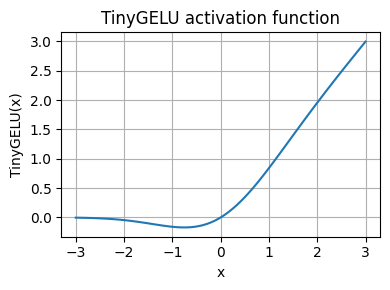

In [8]:
import matplotlib.pyplot as plt

gelu = GELU()

def linspace(start, end, steps):
    return Tensor.arange(steps) * ((end - start) / (steps - 1)) + start

x = linspace(-3, 3, 100)
y_gelu = gelu(x)

plt.figure(figsize=(4, 3))
plt.title(f"TinyGELU activation function")
plt.xlabel("x")
plt.ylabel("TinyGELU(x)")
plt.grid(True)
plt.plot(x.numpy(), y_gelu.numpy())

plt.tight_layout()
plt.show()

In [9]:
class FeedForward:

    def __init__(self, emb_dim: int):
        self.emb_dim = emb_dim
        self.expansion =  nn.Linear(emb_dim, emb_dim * 4, bias=True)    # Expansion
        self.activation = GELU()                                         # Activation
        self.projection = nn.Linear(4 * emb_dim, emb_dim, bias=True)    # Projection (reduction)

    def __call__(self, x: Tensor) -> Tensor:
        x = self.expansion(x)
        x = self.activation(x)
        x = self.projection(x)
        return x


class LayerNorm:
    def __init__(self, emb_dim: int):
        super().__init__()
        self.eps = 1e-5                                           # Epsilon
        self.scale = Tensor.ones(emb_dim, requires_grad=True)     # Gamma
        self.shift = Tensor.zeros(emb_dim, requires_grad=True)    # Beta

    def __call__(self, x: Tensor) -> Tensor:
        mean = x.mean(axis=-1, keepdim=True)
        var = x.var(axis=-1, keepdim=True,  correction=False)
        norm_x = (x - mean) / (var + self.eps).sqrt()
        return self.scale * norm_x + self.shift


class TransformerBlock:

    def __init__(self, cfg: dict[str, object]):
        super().__init__()

        self.attention = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            n_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            bias=cfg['qkv_bias']  
        )

        self.ff = FeedForward(cfg['emb_dim'])
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_rate = cfg['drop_rate']  # applied at multiple levels to prevent overfitting at each level


    def __call__(self, x: Tensor) -> Tensor:
        shortcut = x
        x = self.norm1(x)
        x = self.attention(x)
        x = x.dropout(self.drop_rate)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = x.dropout(self.drop_rate)
        x = x + shortcut

        return x

In [10]:
block = TransformerBlock(GPT_CONFIG_124M)
x = Tensor.rand(2,5,768)
y = block(x)

print(x.numpy())
print(y.numpy())

[[[0.38344753 0.44372582 0.53390443 ... 0.9143466  0.74681854 0.52751124]
  [0.0514853  0.5059414  0.62324333 ... 0.32642472 0.74234366 0.33380938]
  [0.39911366 0.9910134  0.8848647  ... 0.7345259  0.94840825 0.22873878]
  [0.81257474 0.00250328 0.02336907 ... 0.02043915 0.7478622  0.9520525 ]
  [0.02613831 0.32583916 0.29159844 ... 0.7147529  0.43251014 0.7831538 ]]

 [[0.0979892  0.43188393 0.9960046  ... 0.72611034 0.53721416 0.62705123]
  [0.6718372  0.252977   0.24173808 ... 0.05607057 0.60751295 0.41790247]
  [0.8334737  0.5323237  0.7109926  ... 0.5211289  0.5110619  0.17008722]
  [0.6909704  0.68336666 0.9174044  ... 0.37833953 0.5252744  0.5231186 ]
  [0.37710595 0.6624342  0.2080679  ... 0.32915902 0.1228075  0.13681471]]]
[[[ 0.47687268  0.13560627  0.69710654 ...  0.92800057  0.6507147
    1.3987957 ]
  [ 0.08492064  0.74069506  0.82944876 ...  0.69849324  1.0212165
    0.66632164]
  [ 0.64549166  0.99568987  0.7445702  ...  0.6836327   1.0542799
    0.31632346]
  [ 0.8125

### GPT model

In [11]:
# GPT-2 Architecture Overview - Jupyter Visualization

gpt2_architecture = """
╔══════════════════════════════════════════════════════════════════════════════╗
║                           GPT-2 ARCHITECTURE                                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

┌─────────────────────────────────────────────────────────────────────────────┐
│  INPUT                                                                      │
│  "The cat sat on the"                                                       │
└─────────────────────────────────────────────────────────────────────────────┘
                                      │
                                      ▼
┌─────────────────────────────────────────────────────────────────────────────┐
│  TOKENIZER (Byte-Pair Encoding)                                             │
│  "The cat sat on the" → [464, 3797, 3332, 319, 262]                         │
└─────────────────────────────────────────────────────────────────────────────┘
                                      │
                                      ▼
┌─────────────────────────────────────────────────────────────────────────────┐
│  TOKEN EMBEDDING                          POSITIONAL EMBEDDING              │
│  vocab_size (50257) × d_model (768)       max_seq_len (1024) × d_model      │
│           │                                         │                       │
│           └──────────────┬──────────────────────────┘                       │
│                          ▼                                                  │
│                    Element-wise ADD                                         │
│                          │                                                  │
│                          ▼                                                  │
│              Combined Embeddings [seq_len, 768]                             │
└─────────────────────────────────────────────────────────────────────────────┘
                                      │
                                      ▼
┌─────────────────────────────────────────────────────────────────────────────┐
│                                                                             │
│   ╔═══════════════════════════════════════════════════════════════════╗     │
│   ║  TRANSFORMER BLOCK (×12 for GPT-2 Small)                          ║     │
│   ╠═══════════════════════════════════════════════════════════════════╣     │
│   ║                                                                   ║     │
│   ║   Input ──┬──────────────────────────────────────┐                ║     │
│   ║           │                                      │                ║     │
│   ║           ▼                                      │                ║     │
│   ║   ┌───────────────┐                              │                ║     │
│   ║   │  Layer Norm 1 │                              │                ║     │
│   ║   └───────┬───────┘                              │                ║     │
│   ║           │                                      │                ║     │
│   ║           ▼                                      │                ║     │
│   ║   ┌───────────────────────────────────────┐      │                ║     │
│   ║   │  Masked Multi-Head Self-Attention     │      │                ║     │
│   ║   │  (12 heads, d_k = 64 per head)        │      │                ║     │
│   ║   │                                       │      │                ║     │
│   ║   │   Q ─┐                                │      │                ║     │
│   ║   │   K ─┼─► Attention ─► Concat ─► Proj  │      │                ║     │
│   ║   │   V ─┘                                │      │                ║     │
│   ║   └───────────────┬───────────────────────┘      │                ║     │
│   ║                   │                              │                ║     │
│   ║                   ▼                              │                ║     │
│   ║               (+) ADD ◄──────────────────────────┘  Residual 1    ║     │
│   ║                   │                                               ║     │
│   ║           ┌───────┴──────────────────────────────┐                ║     │
│   ║           │                                      │                ║     │
│   ║           ▼                                      │                ║     │
│   ║   ┌───────────────┐                              │                ║     │
│   ║   │  Layer Norm 2 │                              │                ║     │
│   ║   └───────┬───────┘                              │                ║     │
│   ║           │                                      │                ║     │
│   ║           ▼                                      │                ║     │
│   ║   ┌───────────────────────────────────────┐      │                ║     │
│   ║   │  Feed-Forward Network                 │      │                ║     │
│   ║   │                                       │      │                ║     │
│   ║   │  Linear(768 → 3072)                   │      │                ║     │
│   ║   │       │                               │      │                ║     │
│   ║   │       ▼                               │      │                ║     │
│   ║   │     GELU                              │      │                ║     │
│   ║   │       │                               │      │                ║     │
│   ║   │       ▼                               │      │                ║     │
│   ║   │  Linear(3072 → 768)                   │      │                ║     │
│   ║   └───────────────┬───────────────────────┘      │                ║     │
│   ║                   │                              │                ║     │
│   ║                   ▼                              │                ║     │
│   ║               (+) ADD ◄──────────────────────────┘  Residual 2    ║     │
│   ║                   │                                               ║     │
│   ║                   ▼                                               ║     │
│   ║               Output                                              ║     │
│   ║                                                                   ║     │
│   ╚═══════════════════════════════════════════════════════════════════╝     │
│                                      │                                      │
│                              (Repeat ×12)                                   │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
                                      │
                                      ▼
┌─────────────────────────────────────────────────────────────────────────────┐
│  FINAL LAYER NORM                                                           │
│  LayerNorm(768)                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
                                      │
                                      ▼
┌─────────────────────────────────────────────────────────────────────────────┐
│  OUTPUT PROJECTION (Language Model Head)                                    │
│  Linear(768 → 50257)  [Weight tied with token embeddings]                   │
└─────────────────────────────────────────────────────────────────────────────┘
                                      │
                                      ▼
┌─────────────────────────────────────────────────────────────────────────────┐
│  SOFTMAX                                                                    │
│  Probability distribution over vocabulary                                   │
│  P("mat" | "The cat sat on the") = 0.12                                     │
│  P("floor" | "The cat sat on the") = 0.08                                   │
│  ...                                                                        │
└─────────────────────────────────────────────────────────────────────────────┘
                                      │
                                      ▼
┌─────────────────────────────────────────────────────────────────────────────┐
│  OUTPUT                                                                     │
│  Next token prediction: "mat" (or sample from distribution)                 │
└─────────────────────────────────────────────────────────────────────────────┘
"""

print(gpt2_architecture)



╔══════════════════════════════════════════════════════════════════════════════╗
║                           GPT-2 ARCHITECTURE                                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

┌─────────────────────────────────────────────────────────────────────────────┐
│  INPUT                                                                      │
│  "The cat sat on the"                                                       │
└─────────────────────────────────────────────────────────────────────────────┘
                                      │
                                      ▼
┌─────────────────────────────────────────────────────────────────────────────┐
│  TOKENIZER (Byte-Pair Encoding)                                             │
│  "The cat sat on the" → [464, 3797, 3332, 319, 262]                         │
└─────────────────────────────────────────────────────────────────────────────┘
                                   

In [12]:
import tinygrad
import tinygrad.nn

class TinyGPTModel:
    def __init__(self, cfg: dict[str, object]):
        # Embedding
        self.emb_layer = tinygrad.nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_layer = tinygrad.nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_rate = cfg["drop_rate"]

        # Transformer blocks
        self.trf_blocks = [TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        
        # Layer norms
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = tinygrad.nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=True)


    def __call__(self, in_idx: tinygrad.Tensor) -> tinygrad.tensor:
        num_batches, seq_len = in_idx.shape
        embedding = self.emb_layer(in_idx)
        pos_embeddings = self.pos_layer(tinygrad.Tensor.arange(seq_len))

        x = embedding + pos_embeddings
        x = x.dropout(self.drop_rate)
        for block in self.trf_blocks:
            x = block(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

tinygrad.Tensor.manual_seed(42)
tiny = TinyGPTModel(GPT_CONFIG_124M)
input_batch = encoder("Hello, how are you?").unsqueeze(0)
logits = tiny(input_batch)

print(logits.numpy(), logits.shape)

[[[-0.37475854  0.91921234  0.377479   ...  0.19478574  0.04634326
   -0.5028892 ]
  [-0.11838737  0.26292318  0.5065671  ... -0.10617074  0.45981625
   -0.9972051 ]
  [-0.09512917  0.26536468  0.66464454 ... -0.1491879   0.2909158
   -0.98623925]
  [-0.02449884  0.10951907  0.6436204  ... -0.24726972  0.35728818
   -0.81317544]
  [ 0.06015152  0.05567765  0.7080676  ... -0.3271778   0.30426148
   -0.94280696]
  [-0.03009875  0.07611722  0.83187443 ... -0.3352958   0.45460936
   -0.6862832 ]]] (1, 6, 50257)


In [13]:
# count parameters

from tinygrad.nn.state import get_parameters

total_params = sum(p.numel() for p in get_parameters(tiny))
print(f"Total parameters: {total_params:,}")

total_params_gpt2 = total_params - get_parameters(tiny.out_head)[0].numel()
print(f"Total parameters considering weight tying: {total_params_gpt2:,}")  # Should be ~124M

# Exercise 4.1
# Calculate the number of params of the feed forward module and the multi head attention module
ff_params = 0
for p in get_parameters(tiny.trf_blocks[0].ff):
    ff_params += p.numel()
print(f'Each feed forward module has {ff_params:,} parameters, which is in sum {12*ff_params:,}.')

attn_params = 0
for p in get_parameters(tiny.trf_blocks[0].attention):
    attn_params += p.numel()
print(f'Each attention module has {attn_params:,} parameters, which is in sum {12*attn_params:,}.')


Total parameters: 163,138,722
Total parameters considering weight tying: 124,541,346
Each feed forward module has 4,722,432 parameters, which is in sum 56,669,184.
Each attention module has 2,362,368 parameters, which is in sum 28,348,416.


In [14]:
tinygrad.Tensor.manual_seed(42)
tiny = TinyGPTModel(GPT_CONFIG_124M)
input_batch = encoder("Hello, how are").unsqueeze(0)
logits = tiny(input_batch)

In [15]:
max_new_tokens = 6
idx = input_batch
context_size = 1024

print(f'Encoded Input: {idx.numpy()}')
print('Predicting next tokens - one at a time:')

for _ in range(max_new_tokens):
    # Limit the current context
    idx_cond = idx[:, -context_size:]

    # Calculate predictions from the last token.
    # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
    logits = tiny(idx_cond)    
    logits = logits[:, -1, :]

    # Chose the highest probability value
    probas = logits.softmax(axis=-1)
    nxt = probas.argmax(axis=-1, keepdim=True)

    # Append the predicted token to the current sequence
    idx = idx.cat(nxt, dim=1)
    print(idx.numpy())

print('\nGenerated text:', encoder.tokenizer.decode(idx.squeeze(0).tolist()))



Encoded Input: [[15496    11   703   389]]
Predicting next tokens - one at a time:
[[15496    11   703   389  5071]]
[[15496    11   703   389  5071  5071]]
[[15496    11   703   389  5071  5071  5071]]
[[15496    11   703   389  5071  5071  5071  5071]]
[[15496    11   703   389  5071  5071  5071  5071  5071]]
[[15496    11   703   389  5071  5071  5071  5071  5071  7735]]

Generated text: Hello, how are discovered discovered discovered discovered discovered Further


In [16]:
# Download GPT2 weights
import pathlib
import requests as r

BASE_URL = "https://openaipublic.blob.core.windows.net/gpt-2/models"
FILES = [
    "checkpoint", "encoder.json", "hparams.json", 
    "model.ckpt.data-00000-of-00001", "model.ckpt.index", 
    "model.ckpt.meta", "vocab.bpe"
]
MODEL_SIZE = "124M"
MODELS_DIR = "gpt2_weights"

models_dir = pathlib.Path(MODELS_DIR)
models_dir.mkdir(exist_ok=True)

for filename in FILES:
        url = f"{BASE_URL}/{MODEL_SIZE}/{filename}"
        filepath = models_dir.joinpath(filename)
        if not filepath.exists():
            print(f"Downloading {filename}...")
            response = r.get(url)
            with open(filepath, "wb") as f:
                f.write(response.content)


In [17]:
# Load tensorflow checkpoint
import tensorflow as tf

tf_ckpt_path = models_dir.joinpath("model.ckpt")
params = {}

for name, _ in tf.train.list_variables(tf_ckpt_path):
    arr = tf.train.load_variable(tf_ckpt_path, name)
    params[name] = arr

In [18]:
import numpy as np

def to_tensor(arr: np.array) -> Tensor:
    return Tensor(arr.astype(np.float32))

def assign(left: Tensor, right: Tensor):
    if left.shape != right.shape:
        raise ValueError(f'Dimensions mismatch: {left.shape} != {right.shape}')
    return right

In [19]:
tiny_model = TinyGPTModel(GPT_CONFIG_124M)

tiny_model.emb_layer.weight = assign(tiny_model.emb_layer.weight, to_tensor(params["model/wte"]))
tiny_model.pos_layer.weight = assign(tiny_model.pos_layer.weight, to_tensor(params["model/wpe"]))

for i, block in enumerate(tiny_model.trf_blocks):
    # Layer norms
    block.norm1.scale = assign(block.norm1.scale, to_tensor(params[f"model/h{i}/ln_1/g"]))
    block.norm1.shift = assign(block.norm1.shift, to_tensor(params[f"model/h{i}/ln_1/b"]))
    block.norm2.scale = assign(block.norm2.scale, to_tensor(params[f"model/h{i}/ln_2/g"]))
    block.norm2.shift = assign(block.norm2.shift, to_tensor(params[f"model/h{i}/ln_2/b"]))

    # Attention - weights
    qkv_w = params[f"model/h{i}/attn/c_attn/w"][0]  # Shape: (768, 2304)
    q_w, k_w, v_w = np.split(qkv_w, 3, axis=-1)

    block.attention.W_q.weight = assign(block.attention.W_q.weight, to_tensor(q_w.T))
    block.attention.W_k.weight = assign(block.attention.W_k.weight, to_tensor(k_w.T))
    block.attention.W_v.weight = assign(block.attention.W_v.weight, to_tensor(v_w.T))

    # Attention - bias
    qkv_b = params[f"model/h{i}/attn/c_attn/b"]
    q_b, k_b, v_b = np.split(qkv_b, 3, axis=-1)

    block.attention.W_q.bias = assign(block.attention.W_q.bias, to_tensor(q_b))
    block.attention.W_k.bias = assign(block.attention.W_k.bias, to_tensor(k_b))
    block.attention.W_v.bias = assign(block.attention.W_v.bias, to_tensor(v_b))

    # Attention = Output projection
    block.attention.out_proj.weight = assign(block.attention.out_proj.weight, to_tensor(params[f"model/h{i}/attn/c_proj/w"][0].T))
    block.attention.out_proj.bias = assign(block.attention.out_proj.bias, to_tensor(params[f"model/h{i}/attn/c_proj/b"]))

    # FFN
    block.ff.expansion.weight = assign(block.ff.expansion.weight, to_tensor(params[f"model/h{i}/mlp/c_fc/w"][0].T))
    block.ff.expansion.bias = assign(block.ff.expansion.bias, to_tensor(params[f"model/h{i}/mlp/c_fc/b"]))
    block.ff.projection.weight = assign(block.ff.projection.weight, to_tensor(params[f"model/h{i}/mlp/c_proj/w"][0].T))
    block.ff.projection.bias = assign(block.ff.projection.bias, to_tensor(params[f"model/h{i}/mlp/c_proj/b"]))
    

# Final norm
tiny_model.final_norm.scale = to_tensor(params["model/ln_f/g"])
tiny_model.final_norm.shift = to_tensor(params["model/ln_f/b"])

# Output head
tiny_model.out_head.weight = to_tensor(params["model/wte"])

In [ ]:
from IPython.display import display, HTML, clear_output

input_batch = encoder("Hello world in Python").unsqueeze(0)
logits = tiny_model(input_batch)

max_new_tokens = 100
idx = input_batch
context_size = 1024

print(f'Encoded Input: {idx.numpy()}')

for _ in range(max_new_tokens):
    # Limit the current context
    idx_cond = idx[:, -context_size:]

    # Calculate predictions from the last token.
    # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
    logits = tiny_model(idx_cond)    
    logits = logits[:, -1, :]

    # Chose the highest probability value
    probas = logits.softmax(axis=-1)
    nxt = probas.argmax(axis=-1, keepdim=True)

    # Append the predicted token to the current sequence
    idx = idx.cat(nxt, dim=1)
    #print(idx.numpy())

    output = encoder.tokenizer.decode(idx.squeeze(0).tolist())
    clear_output(wait=True)
    print(output, end="", flush=True)


Hello world in Python, you can use the following to create a new Python script:

from flask import Flask from flask.py import Flask_